# The purpose of this notebook

In discussion with Michael, I mentioned that we support our use of a linear model of the suppression data by showing that it has better mean and median R^2 than a linear fit to the log-logged data. However, both box plots of fits showed a group of curves (each being one eye of one patient viewing the target under a certain surround/presentation condition etc) that were very badly fit by either model, like near zero and enough to be outliers on a boxplot. So, we thought maybe we'd remove them and see if that changes the results. That's what I'm attempting to do here; The immediately previous notebook, whose graphs are in redo-201901, are the comparison (these are in redo-2901902-exclude_bad_fits)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import string

import numpy as np
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import suppression as s
import utils
import linear_model

In [4]:
pd.__version__

'0.24.2'

In [5]:
sns.__version__

'0.9.0'

In [6]:
gaba_fn = 'gaba_data_2019.txt'
supp_fn = 'supp_data_individual_20170427.txt'

In [7]:
sdf = utils.load_psychophys(supp_fn)
gaba_col = 'mean_occ_all' #'motor' # or 'occ_binoc', 'mean_occ_all', 'motor'
gdf = utils.load_gaba(gaba_fn, gaba_col)

In [8]:
# Set the Population to be a categorical variable and change the names

In [9]:
#sdf.Population = sdf.Population.astype('category')
#sdf.Population.cat.categories # 0 AMB 1 CON
#sdf.Population = sdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted individuals'])

In [10]:
#sdf['Eye'] = sdf['Eye'].astype('category')

In [11]:
gdf.Population = gdf.Population.astype('category')
gdf.Population.cat.categories # 0 AMB 1 CON
gdf.Population = gdf.Population.cat.rename_categories(['Persons with Amblyopia', 'Normally-sighted individuals'])

### Set variables used for graphing

In [12]:
colors_amb = ["#3274a1","#72b4e1"]
colors_con = ["#e1812c", "#ffc68c"]
colors4 = colors_amb + colors_con
traces4 = ['Amblyope-De', 'Amblyope-Nde', 'Control-De', 'Control-Nde']
traces_graph4 = [f"Persons with\nAmblyopia, DE", f"Persons with\nAmblyopia, NDE", \
                 f"Normally-sighted\nindividuals, DE", f"Normally-sighted\nindividuals, NDE"]
plot_dir = f"plots/redo-201904-{gaba_col}"

## Analyze tasks separately (before subsetting to include common subjects)##

In [13]:
pp_subjs = np.unique(sdf.Subject)
n_pp_subjs = len(pp_subjs)
gaba_subjs = np.unique(gdf.subjName)
n_gaba_subjs = len(gaba_subjs)
print(f"Psychophysics subjects (n={n_pp_subjs}):\n", pp_subjs)
print(f"GABA subjects (n={n_gaba_subjs}):\n", gaba_subjs)

Psychophysics subjects (n=37):
 ['ah' 'ai' 'am' 'ap' 'bi' 'bo' 'cl' 'cr' 'ct' 'dl' 'ds' 'eg' 'ei' 'em'
 'es' 'gd' 'gm' 'gw' 'jd' 'jv' 'ke' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'mv'
 'nl' 'nn' 'rn' 'sd' 'se' 'tj' 'tm' 'tt' 'yl']
GABA subjects (n=31):
 ['ac' 'ai' 'am' 'as' 'bi' 'ch' 'cr' 'cs' 'ct' 'dl' 'ei' 'em' 'es' 'gd'
 'gm' 'jd' 'jm' 'jv' 'ks' 'kw' 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'ps' 'rn'
 'sd' 'tt' 'yl']


# GABA only analyses

### GABA t-test, CON v AMB

In [14]:
gdf

,subjName,Population,Presentation,GABA
2,ac,Persons with Amblyopia,mean_occ_all,0.198
6,am,Persons with Amblyopia,mean_occ_all,0.194
10,as,Persons with Amblyopia,mean_occ_all,0.217
14,bi,Persons with Amblyopia,mean_occ_all,0.205
18,ch,Persons with Amblyopia,mean_occ_all,0.184
22,cs,Persons with Amblyopia,mean_occ_all,0.220
26,em,Persons with Amblyopia,mean_occ_all,0.185
30,gd,Persons with Amblyopia,mean_occ_all,0.197
34,jv,Persons with Amblyopia,mean_occ_all,0.201
38,ks,Persons with Amblyopia,mean_occ_all,0.207


In [15]:
pop_group = gdf.groupby("Population")
pop_group.describe(percentiles=[.5])

GABA                                          
                             count      mean       std    min     50%    max
Population                                                                  
Persons with Amblyopia        16.0  0.199813  0.015276  0.162  0.2005  0.220
Normally-sighted individuals  15.0  0.205800  0.009443  0.193  0.2030  0.223

In [16]:
gaba_per_group = [col for col_name, col in pop_group['GABA']]
(tstat, pval) = st.ttest_ind(*gaba_per_group, nan_policy='omit')
print(tstat, pval)

-1.30189405829905 0.20319932494233123


**Thus we find no significant difference in GABA levels between CON and AMB.**

### GABA violin plot, all subjects

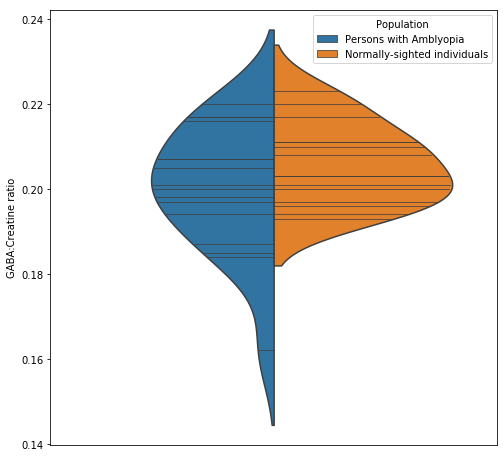

In [17]:
with s.PdfPages(f"{plot_dir}/gaba_diffs_n{n_gaba_subjs}_{gaba_col}.pdf") as pdf:
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.violinplot(y='GABA',x='Presentation',hue='Population',data=gdf,split=True,inner='stick',ax=ax,legend=False)
    #ax.legend_.remove()
    ax.xaxis.set_visible(False)
    ax.set_ylabel('GABA:Creatine ratio')
    #ax.set_yticklabels([])
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')

### Note: the subject with the lowest GABA:Cr ('tt', .162) is not in the psychophysics data

# Select one psychophysical task's data #

In [18]:
task = 'SS'
sdf = sdf[sdf['Task']==task]

In [19]:
df_to_model = sdf.copy() # make a deep copy

In [20]:
n_pp_subjs_thistask = len(np.unique(df_to_model.Subject))
amb_subjs = np.unique(df_to_model[df_to_model["Population"]=="Amblyope"]["Subject"])
print(amb_subjs)
n_amb_subjs_thistask = len(amb_subjs)
print(f"There are {n_pp_subjs_thistask} subjects for Task {task}, of which {n_amb_subjs_thistask} are Amblyopes.")

['ah' 'am' 'bi' 'cl' 'eg' 'em' 'gd' 'jv' 'li' 'mg' 'mv' 'rn' 'sd']
There are 35 subjects for Task SS, of which 13 are Amblyopes.


# Modeling

In [21]:
df_to_model.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527


### Begin grouping data into conditions to model Subject's ThreshElev as a function of logRelContrast #

In [22]:
pp_gvars = ['Task','Orientation','Presentation','Population','Subject','Eye','Trace'] # One condition
pp_gvars_base = pp_gvars + ['BaselineThresh']

In [23]:
groups_with_baseline = df_to_model.groupby(pp_gvars_base)

In [24]:
# Check if there are any conditions with only two data points
for gv, gr in groups_with_baseline:
    if len(gr)<=2:
        print(gv, gr)

#### BaselineThresh analysis before we exclude bad fits; since this is observed not modeled its ok

In [25]:
print(pp_gvars_base)
pp_gvars_base_agg = [v for v in pp_gvars if v != 'Subject']

['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye', 'Trace', 'BaselineThresh']


In [26]:
pp_gvars_base_agg

['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace']

In [27]:
for gv, g in df_to_model.groupby(pp_gvars_base_agg):
    print(gv, len(np.unique(g['BaselineThresh'])))

('SS', 'Cross', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Cross', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Cross', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Cross', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Cross', 'nMono', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nDicho', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nDicho', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nDicho', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nDicho', 'Control', 'Nde', 'Control-Nde') 22
('SS', 'Iso', 'nMono', 'Amblyope', 'De', 'Amblyope-De') 13
('SS', 'Iso', 'nMono', 'Amblyope', 'Nde', 'Amblyope-Nde') 13
('SS', 'Iso', 'nMono', 'Control', 'De', 'Control-De') 16
('SS', 'Iso', 'nMono', 'Control', 'Nde', 'Control-Nde') 22


In [28]:
def test_baseline_diffs(g):
    print(g.iloc[0])
    ndes = np.unique(g[g.Eye=='Nde']['BaselineThresh'])
    des = np.unique(g[g.Eye=='De']['BaselineThresh'])
    print(ndes, len(ndes), '\n', des, len(des))
    print(st.ttest_ind(ndes, des))

df_to_model.groupby(['Task', 'Orientation', 'Presentation', 'Population']).apply(test_baseline_diffs)

Subject                               ah
Task                                  SS
Presentation                      nDicho
Orientation                        Cross
Eye                                  Nde
Population                      Amblyope
MaskContrast                          10
ThreshElev                          1.23
ThreshElev_SE                      0.008
RelMaskContrast                    1.318
Trace                       Amblyope-Nde
BaselineThresh                     4.558
BinCenterRelMaskContrast           1.432
BinNumber                              2
logThreshElev                  0.0899051
logRelMaskContrast              0.119915
Name: 816, dtype: object
[ 4.558  4.764  5.654  5.944  6.014  6.536  6.787  7.316  7.458  7.834
  8.907 10.141 13.226] 13 
 [4.063 4.174 4.227 5.949 5.981 6.21  6.262 6.424 6.709 6.826 7.532 7.59
 7.827] 13
Ttest_indResult(statistic=1.5848909585669702, pvalue=0.12608067735589273)
Subject                               ah
Task                  

""


In [29]:
def describe_baselines(g):
    N = len(np.unique(g['BaselineThresh']))
    baseline_mean = g['BaselineThresh'].mean()
    baseline_std = np.unique(g['BaselineThresh']).std()
    baseline_SEM = baseline_std/np.sqrt(N)
    d = {'N':N, 'mean':baseline_mean, 'std':baseline_std, 'SEM':baseline_SEM}
    return pd.Series(d)

baseline_df = df_to_model.groupby(pp_gvars_base_agg).apply(describe_baselines).reset_index()

In [30]:
baseline_df_reduced = baseline_df[(baseline_df.Orientation=='Cross') & (baseline_df.Presentation=='nMono')]

In [31]:
baseline_df_reduced

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM
4,SS,Cross,nMono,Amblyope,De,Amblyope-De,13.0,6.137774,1.230422,0.341258
5,SS,Cross,nMono,Amblyope,Nde,Amblyope-Nde,13.0,7.299288,2.271492,0.629998
6,SS,Cross,nMono,Control,De,Control-De,16.0,6.306926,1.509734,0.377434
7,SS,Cross,nMono,Control,Nde,Control-Nde,22.0,5.879193,1.395699,0.297564


In [32]:
def get_interocular_baseline_diff(g):
    if len(g) < 2:
        return g
    else:
        assert(len(g)==2)
        nde_mean = g[g.Eye=='Nde']['mean'].iloc[0]
        de_mean = g[g.Eye=='De']['mean'].iloc[0]
        g['BaselineDiff'] = nde_mean - de_mean
        return g

def make_baseline_df_to_plot(df):
    return df.groupby('Population').apply(get_interocular_baseline_diff)

In [33]:
baseline_plot_df = make_baseline_df_to_plot(baseline_df_reduced)

In [34]:
baseline_plot_df.head()

,Task,Orientation,Presentation,Population,Eye,Trace,N,mean,std,SEM,BaselineDiff
4,SS,Cross,nMono,Amblyope,De,Amblyope-De,13.0,6.137774,1.230422,0.341258,1.161515
5,SS,Cross,nMono,Amblyope,Nde,Amblyope-Nde,13.0,7.299288,2.271492,0.629998,1.161515
6,SS,Cross,nMono,Control,De,Control-De,16.0,6.306926,1.509734,0.377434,-0.427733
7,SS,Cross,nMono,Control,Nde,Control-Nde,22.0,5.879193,1.395699,0.297564,-0.427733


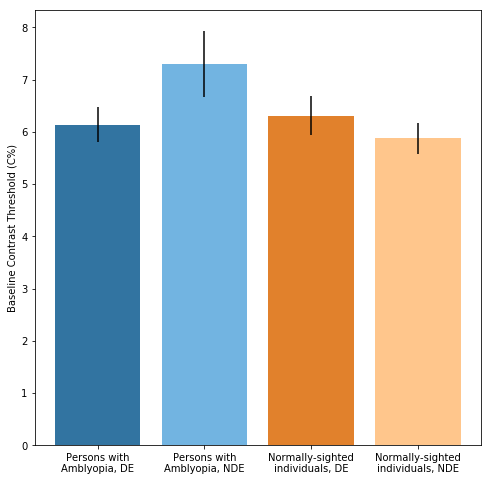

In [35]:
with s.PdfPages(f"{plot_dir}/{task}_baseline_diffs.pdf") as pdf:
    fig = plt.figure(figsize=(8,8))  # create a figure object
    ax = fig.add_subplot(1, 1, 1)
    x_pos = np.arange(len(baseline_plot_df['Trace']))
    plt.bar(x_pos, baseline_plot_df['mean'], data=baseline_plot_df, yerr='SEM', color=colors4)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(traces_graph4)
    ax.set_ylabel('Baseline Contrast Threshold (C%)')
    plt.show(ax.figure)
    pdf.savefig(ax.figure)
    plt.close(ax.figure)
    plt.close('all')
    

### Linear model using statsmodels

In [36]:
import statsmodels.formula.api as sm

def linear_fit(df, x, y):
    result = sm.ols(formula=f"{y} ~ {x}", data=df).fit()
    return result

def linear_fit_params(df, x, y):
    result = linear_fit(df, x, y)
    ret = result.params
    ret.index = ret.index.str.replace(x, 'slope').str.replace('Intercept','y_int')
    fit_df = ret.append(pd.Series({'rsquared':result.rsquared}))
    return fit_df

In [37]:
lin_results = groups_with_baseline.apply(linear_fit_params, 'RelMaskContrast', 'ThreshElev').reset_index()

In [38]:
lin_results.head(n=16)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389
2,SS,Cross,nDicho,Amblyope,am,De,Amblyope-De,7.532,0.473458,0.008358,0.150669
3,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,1.035803,0.079161,0.878492
4,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,0.859762,0.014954,0.546837
5,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,0.712554,0.244377,0.992124
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
7,SS,Cross,nDicho,Amblyope,cl,Nde,Amblyope-Nde,7.458,1.044474,0.761080,0.943153
8,SS,Cross,nDicho,Amblyope,eg,De,Amblyope-De,6.826,0.986000,0.039389,0.722331
9,SS,Cross,nDicho,Amblyope,eg,Nde,Amblyope-Nde,6.787,1.004564,0.026249,0.659700


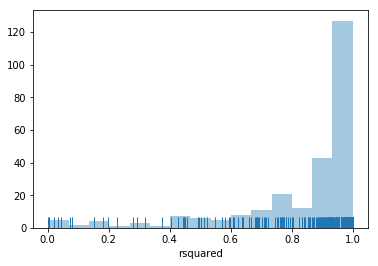

In [39]:
sns.distplot(lin_results.rsquared, kde=False, rug=True)

In [40]:
np.count_nonzero(lin_results.rsquared>.99999)

1

In [41]:
lin_results.rsquared.mean()

0.8354424459253054

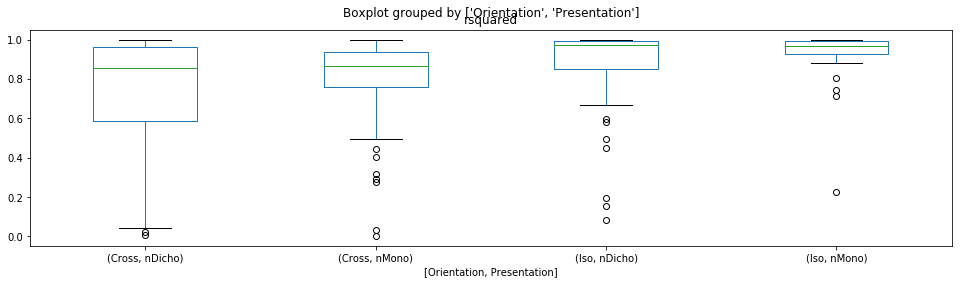

In [42]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Presentation'], grid=False, figsize=(16, 4))

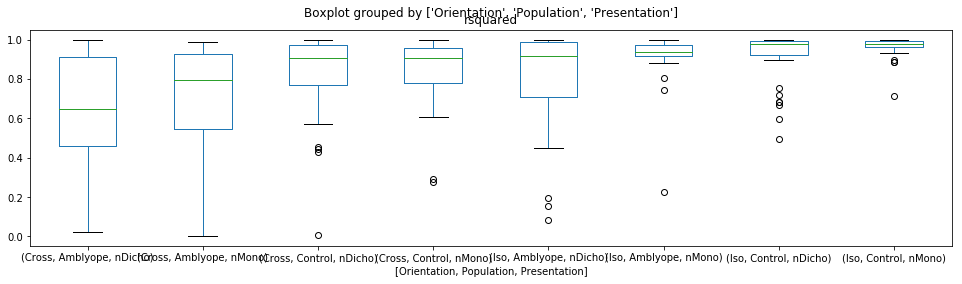

In [43]:
lin_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

### Fit the log-logged data to see if that's better

In [44]:
log_results = groups_with_baseline.apply(linear_fit_params, 'logRelMaskContrast', 'logThreshElev').reset_index()

In [45]:
log_results.rsquared.mean()

0.7417445472530506

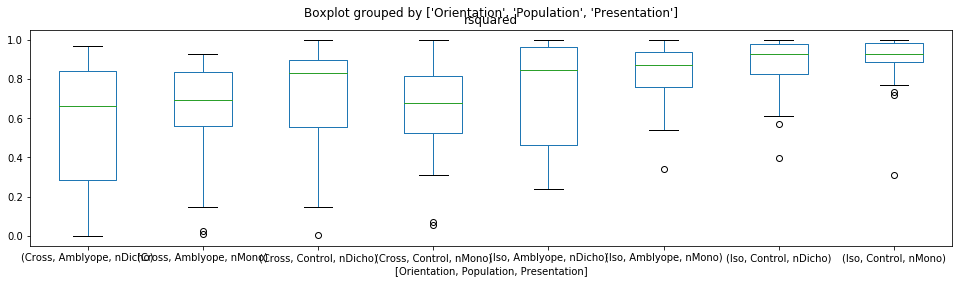

In [46]:
log_results.boxplot(column='rsquared', by=['Orientation', 'Population', 'Presentation'], grid=False, figsize=(16, 4))

## Conclusion: linear fits are overall better.

## Identify subjects with negative slope (for Jian)

In [47]:
neg_slopes = lin_results[lin_results['slope']<0]
neg_slopes

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared
6,SS,Cross,nDicho,Amblyope,cl,De,Amblyope-De,6.709,1.021385,-0.032079,0.523622
12,SS,Cross,nDicho,Amblyope,gd,De,Amblyope-De,6.210,1.023065,-0.006021,0.045044
14,SS,Cross,nDicho,Amblyope,jv,De,Amblyope-De,4.227,1.689517,-0.020405,0.181212
20,SS,Cross,nDicho,Amblyope,mv,De,Amblyope-De,5.981,1.260735,-0.020939,0.503098
22,SS,Cross,nDicho,Amblyope,rn,De,Amblyope-De,6.424,0.757355,-0.017022,0.021744
24,SS,Cross,nDicho,Amblyope,sd,De,Amblyope-De,6.262,0.706531,-0.017487,0.073372
53,SS,Cross,nDicho,Control,ms,Nde,Control-Nde,4.214,0.942228,-0.004734,0.622978
78,SS,Cross,nMono,Amblyope,jv,De,Amblyope-De,4.227,1.861288,-0.038142,0.319723
86,SS,Cross,nMono,Amblyope,rn,De,Amblyope-De,6.424,0.933673,-0.033097,0.494020
132,SS,Iso,nDicho,Amblyope,bi,De,Amblyope-De,7.827,1.006648,-0.013177,0.152790


In [48]:
neg_slopes.Subject.unique()

array(['cl', 'gd', 'jv', 'mv', 'rn', 'sd', 'ms', 'bi', 'ct'], dtype=object)

## Exclude bad fits (new 2019-02-25)

In [49]:
len(lin_results)

256

In [50]:
def remove_outliers_iqr(g):
    "Remove values failing the 1.5 * IQR rule"
    q1 = g['rsquared'].quantile(.25)
    q3 = g['rsquared'].quantile(.75)
    iqr = q3 - q1
    mask = g['rsquared'].between(q1-1.5*iqr, q3+1.5*iqr, inclusive=True)
    return g.loc[mask]

def remove_outliers_halfvar(g):
    "Remove values failing the 50% variance explained (R^2 > .5) rule"
    mask = g['rsquared'].between(.5, 1, inclusive=True)
    return g.loc[mask]

In [51]:
lin_results_exc = lin_results.groupby(['Task', 'Population']).apply(remove_outliers_halfvar).reset_index(drop=True)

In [52]:
lin_results_exc.rsquared.min()

0.5030976163556411

In [53]:
lin_results_exc.Subject.value_counts().sum()

231

In [54]:
231/256

0.90234375

In [55]:
pp_subs_exc = lin_results_exc.Subject.unique()
print(f'There are {len(pp_subs_exc)} unique subjects who have at least one condition of data.')

There are 35 unique subjects who have at least one condition of data.


## Actually use the linear model to predict thresholds

In [56]:
def linear_fit_predictions(df, x, y):
    result = linear_fit(df, x, y)
    preds = pd.Series(result.predict(), index=df[x], name='ThreshPred')
    return preds

In [57]:
lin_preds = groups_with_baseline.apply(linear_fit_predictions, 'RelMaskContrast', 'ThreshElev').reset_index()

In [58]:
lin_preds.columns

Index(['Task', 'Orientation', 'Presentation', 'Population', 'Subject', 'Eye',
       'Trace', 'BaselineThresh', 'RelMaskContrast', 'ThreshPred'],
      dtype='object')

In [59]:
lin_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.318,1.411635


In [60]:
plot_df = pd.merge(df_to_model, lin_preds, on=pp_gvars_base + ['RelMaskContrast'])

In [61]:
plot_df.columns

Index(['Subject', 'Task', 'Presentation', 'Orientation', 'Eye', 'Population',
       'MaskContrast', 'ThreshElev', 'ThreshElev_SE', 'RelMaskContrast',
       'Trace', 'BaselineThresh', 'BinCenterRelMaskContrast', 'BinNumber',
       'logThreshElev', 'logRelMaskContrast', 'ThreshPred'],
      dtype='object')

In [62]:
plot_df.head()

,Subject,Task,Presentation,Orientation,Eye,Population,MaskContrast,ThreshElev,ThreshElev_SE,RelMaskContrast,Trace,BaselineThresh,BinCenterRelMaskContrast,BinNumber,logThreshElev,logRelMaskContrast,ThreshPred
0,ai,SS,nMono,Iso,Nde,Control,10.0,0.615,0.009,1.449,Control-Nde,6.900,1.552,2,-0.211125,0.161068,0.475863
1,ai,SS,nMono,Iso,Nde,Control,30.0,0.671,0.010,4.348,Control-Nde,6.900,3.944,4,-0.173277,0.638290,0.897104
2,ai,SS,nMono,Iso,Nde,Control,62.0,1.658,0.007,8.986,Control-Nde,6.900,11.345,6,0.219585,0.953566,1.571032
3,ap,SS,nMono,Iso,Nde,Control,5.0,1.277,0.007,0.961,Control-Nde,5.205,0.960,1,0.106191,-0.017277,0.656604
4,ap,SS,nMono,Iso,Nde,Control,10.0,1.096,0.004,1.921,Control-Nde,5.205,1.552,2,0.039811,0.283527,0.977298


### Plot observed values and model fits

In [63]:
s.group_facet_plots(plot_df, s.subject_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Subject",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201904-mean_occ_all/SS_regressions_combinedplots_n35_TOP.pdf


In [64]:
s.group_facet_plots(plot_df, s.population_fit_plot,
                    f"{plot_dir}/{task}_regressions_combinedplots_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast", y="ThreshElev", # x, y
                    hue="Population",yerr='ThreshElev_SE',fmt_obs='.',fmt_pred='x:',Ycol="ThreshPred") 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201904-mean_occ_all/SS_regressions_combinedplots_n35_TO.pdf


## Now exclude the predictions for the bad fits

In [65]:
lin_results.Orientation.value_counts()

Iso      128
Cross    128
Name: Orientation, dtype: int64

In [66]:
lin_results_exc.Orientation.value_counts()

Iso      122
Cross    109
Name: Orientation, dtype: int64

In [67]:
lin_results_exc.Population.value_counts()

Control     145
Amblyope     86
Name: Population, dtype: int64

In [68]:
lin_results.Population.value_counts()

Control     152
Amblyope    104
Name: Population, dtype: int64

In [69]:
comb_rsq_preds = pd.merge(lin_results_exc, lin_preds, on=pp_gvars_base)

In [70]:
comb_rsq_preds.rsquared.min()

0.5030976163556411

In [71]:
comb_rsq_preds.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,2.194,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,3.949,0.772811
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,7.020,0.825863
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,12.286,0.916833
4,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,1.305603,0.080449,0.638389,1.318,1.411635


In [72]:
comb_rsq_preds[comb_rsq_preds.Subject=='tt']

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,RelMaskContrast,ThreshPred


### Pick an xvalue (RelMaskContrast) to evaluate models at

 * 2018-09-24: Abandoning Eunice's binning. Instead, try to figure out a good RelMaskContrast programatically.
   * Just looking at it via describe(), i'd say somewhere between 5 and 10 -- probably 6 (for SS) and 10 (for OS)
 * 2018-10-08: My previous approach was too subjective. Instead, evaluate model at various percentiles...
   * do this separately for Task, Orientation, Presentation (so pick 8 total numbers)
   * At this point it's easier to just use the statsmodels.ols functions maybe? The way it's currently done is a legacy that allows different models to be swapped in... which I hope to god is not going to be the direction we go in again.
   * nvm, used the lmfit solution since it returned a nicely formatted pfit df and is tested to work
   * Here I want to take the slope and y-int and calculate the model prediction at the specified percentiles above (0-1, increments of 0.2). So, first calculate the RelMC at each of those percentiles, then apply it like below.


In [73]:
percentile_bins = np.linspace(0, 1, num=11)

In [74]:
percentile_bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

#### Get the interpolated RelMaskContrasts for each regression line, i.e. the range of x-values

In [75]:
relmc_pcts_df = comb_rsq_preds.groupby(pp_gvars_base)['RelMaskContrast'].describe(percentiles=percentile_bins)

In [76]:
# fix stupid column naming from describe()
relmc_pcts_df.columns = [f"{int(float(col[:-1])):03d}" if col[-1]=="%" else col for col in relmc_pcts_df.columns]

In [77]:
relmc_pcts_df.columns

Index(['count', 'mean', 'std', 'min', '000', '010', '020', '030', '040', '050',
       '060', '070', '080', '090', '100', 'max'],
      dtype='object')

In [78]:
relmc_pcts_df = relmc_pcts_df.filter(regex='0|1')
relmc_pcts_df.head()

000  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh          
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.194   
                                                 Nde Amblyope-Nde 4.558           1.318   
                                         am      Nde Amblyope-Nde 7.834           1.328   
                                         bi      De  Amblyope-De  7.827           0.986   
                                                 Nde Amblyope-Nde 10.141          1.278   

                                                                                     010  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           2.7205   
                                                 Nde Amblyope-Nde 4.558           1.6342   
                                         am      Nde Amblyope-Nde 7.834           1.7528   
                                         bi      De  Amblyope-De  7.827           1.3804   
                                                 Nde Amblyope-Nde 10.141          1.7890   

                                                                                     020  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.2470   
                                                 Nde Amblyope-Nde 4.558           1.9504   
                                         am      Nde Amblyope-Nde 7.834           2.1776   
                                         bi      De  Amblyope-De  7.827           1.7748   
                                                 Nde Amblyope-Nde 10.141          2.3000   

                                                                                     030  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           3.7735   
                                                 Nde Amblyope-Nde 4.558           2.2666   
                                         am      Nde Amblyope-Nde 7.834           2.7618   
                                         bi      De  Amblyope-De  7.827           2.1692   
                                                 Nde Amblyope-Nde 10.141          2.8110   

                                                                                     040  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           4.5632   
                                                 Nde Amblyope-Nde 4.558           2.7408   
                                         am      Nde Amblyope-Nde 7.834           3.5054   
                                         bi      De  Amblyope-De  7.827           2.5636   
                                                 Nde Amblyope-Nde 10.141          3.3220   

                                                                                     050  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyope   ah      De  Amblyope-De  7.590           5.4845   
                                                 Nde Amblyope-Nde 4.558           3.2940   
                                         am      Nde Amblyope-Nde 7.834           4.2490   
                                         bi      De  Amblyope-De  7.827           2.9580   
                                                 Nde Amblyope-Nde 10.141          3.8330   

                                                                                     060  \
Task Orientation Presentation Population Subject Eye Trace        BaselineThresh           
SS   Cross       nDicho       Amblyop

In [79]:
relmc_pcts_df.columns

Index(['000', '010', '020', '030', '040', '050', '060', '070', '080', '090',
       '100'],
      dtype='object')

In [80]:
relmc_pcts_df_melted = relmc_pcts_df.reset_index().melt(id_vars=pp_gvars_base, var_name='percentile', value_name='RelMaskContrast_pct')

In [81]:
relmc_pcts_df_melted.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,000,2.194
1,SS,Cross,nDicho,Amblyope,ah,Nde,Amblyope-Nde,4.558,000,1.318
2,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,7.834,000,1.328
3,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,7.827,000,0.986
4,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,10.141,000,1.278


In [82]:
predict_pcts_df = pd.merge(lin_results_exc, relmc_pcts_df_melted, on=pp_gvars_base)

In [83]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,000,2.1940
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,010,2.7205
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,020,3.2470
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,030,3.7735
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,040,4.5632


In [84]:
predict_pcts_df['percentile'] = predict_pcts_df['percentile'].astype(int)
predict_pcts_df['RelMaskContrast_pct'] = predict_pcts_df['RelMaskContrast_pct'].astype(float)
predict_pcts_df['relmc_bin'] = (np.around(predict_pcts_df['RelMaskContrast_pct'])).astype(int)
predict_pcts_df['ThreshElev_pct'] = (predict_pcts_df['y_int'] + (predict_pcts_df['RelMaskContrast_pct']*predict_pcts_df['slope'])).astype('float')

In [85]:
predict_pcts_df.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,0,2.1940,2,0.742493
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,10,2.7205,3,0.751589
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,20,3.2470,3,0.760684
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,30,3.7735,4,0.769779
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.59,0.704592,0.017275,0.639823,40,4.5632,5,0.783421


In [86]:
predict_pcts_df.rsquared.min()

0.5030976163556411

### Plot the model fits only

In [87]:
s.group_facet_plots(predict_pcts_df, s.subject_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TOP.pdf",
                    ['Task','Orientation','Presentation'], #each combo of this gets its own page
                    row='Population',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="Subject",fmt_obs='.') 

Plotting SS.Cross.nDicho
Plotting SS.Cross.nMono
Plotting SS.Iso.nDicho
Plotting SS.Iso.nMono
Plots saved at plots/redo-201904-mean_occ_all/SS_regressions_pcts_n35_TOP.pdf


In [88]:
s.group_facet_plots(predict_pcts_df, s.population_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TO.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="Population",fmt_obs='.') 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201904-mean_occ_all/SS_regressions_pcts_n35_TO.pdf


In [89]:
s.group_facet_plots(predict_pcts_df, s.population_fit_plot_pct,
                    f"{plot_dir}/{task}_regressions_pcts_n{n_pp_subjs_thistask}_TO_bin.pdf",
                    ['Task','Orientation'], #each combo of this gets its own page
                    row='Presentation',col='Eye',# facet rows and columns
                    x="RelMaskContrast_pct", y="ThreshElev_pct", # x, y
                    hue="relmc_bin",fmt_obs='.') 

Plotting SS.Cross
Plotting SS.Iso
Plots saved at plots/redo-201904-mean_occ_all/SS_regressions_pcts_n35_TO_bin.pdf


### Conclusions from these regression plots (_TO):
 * SS: looks fine, esp with new binning (IMO).
 * OS: one or two subjects really messes up the axes. One bc of a huge error bar on their observed ThreshElev, one but v low predicted ThreshElev by model; exclude? Both are controls so part of the larger group.
   * This only happens in Iso-orientation, which is different from Cross in substantial ways. What does that indicate?

In [90]:
gvars_test = ['Task','Orientation','Presentation','Population']
# equal_var=False makes it Welch's t-test, which does not assume the groups have equal variance
selected_bin_df = utils.find_pct_to_predict(predict_pcts_df, gvars_test,
                    'relmc_bin', 'ThreshElev_pct', test_func=st.ttest_ind, equal_var=False)

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p-value: 0.0001217267
10 DE obs, 17 NDE obs
p-value: 0.0026591129
8 DE obs, 14 NDE obs
p-value: 0.0073737492
8 DE obs, 12 NDE obs
p-value: 0.0344970562
4 DE obs, 13 NDE obs
p-value: 0.0082892146
2 DE obs, 8 NDE obs
p-value: 0.0336034718
3 DE obs, 4 NDE obs
p-value: 0.3643803918
3 DE obs, 5 NDE obs
p-value: 0.0423860511
1 DE obs, 4 NDE obs
p-value: nan
1 DE obs, 4 NDE obs
p-value: nan
2 DE obs, 3 NDE obs
p-value: 0.3205767408
A group with no obs, skipping
A group with no obs, skipping
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 2 has lowest p-value.

There are 20 bins in this condition.
10 DE obs, 21 NDE obs
p-value: 0.0015354314
10 DE obs, 21 NDE obs
p-value: 0.0015354314
13 DE obs, 28 NDE obs
p

//anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


4 DE obs, 7 NDE obs
p-value: 0.1275112282
4 DE obs, 6 NDE obs
p-value: 0.9799062190
4 DE obs, 5 NDE obs
p-value: 0.0351302295
3 DE obs, 3 NDE obs
p-value: 0.0130473171
3 DE obs, 6 NDE obs
p-value: 0.4436764191
2 DE obs, 3 NDE obs
p-value: 0.3027563230
1 DE obs, 3 NDE obs
p-value: nan
1 DE obs, 2 NDE obs
p-value: nan
2 DE obs, 3 NDE obs
p-value: 0.7921966302
1 DE obs, 2 NDE obs
p-value: nan
1 DE obs, 2 NDE obs
p-value: nan
A group with no obs, skipping
A group with no obs, skipping
A group with no obs, skipping
relmc_bin 14 has lowest p-value.

There are 20 bins in this condition.
Not in suppression, mean of both eyes is < 1.
Not in suppression, mean of both eyes is < 1.
21 DE obs, 19 NDE obs
p-value: 0.0000100009
13 DE obs, 15 NDE obs
p-value: 0.0061183441
15 DE obs, 10 NDE obs
p-value: 0.0089245450
10 DE obs, 8 NDE obs
p-value: 0.0704511526
12 DE obs, 5 NDE obs
p-value: 0.3058439511
7 DE obs, 2 NDE obs
p-value: 0.1909077381
5 DE obs, 4 NDE obs
p-value: 0.2747719287
3 DE obs, 2 NDE obs

   Task Orientation Presentation Population Subject  Eye         Trace  \
12   SS       Cross       nDicho   Amblyope      ah  Nde  Amblyope-Nde   
13   SS       Cross       nDicho   Amblyope      ah  Nde  Amblyope-Nde   
14   SS       Cross       nDicho   Amblyope      ah  Nde  Amblyope-Nde   
23   SS       Cross       nDicho   Amblyope      am  Nde  Amblyope-Nde   
24   SS       Cross       nDicho   Amblyope      am  Nde  Amblyope-Nde   

    BaselineThresh     y_int     slope  rsquared  percentile  \
12           4.558  1.305603  0.080449  0.638389          10   
13           4.558  1.305603  0.080449  0.638389          20   
14           4.558  1.305603  0.080449  0.638389          30   
23           7.834  1.035803  0.079161  0.878492          10   
24           7.834  1.035803  0.079161  0.878492          20   

    RelMaskContrast_pct  relmc_bin  ThreshElev_pct  BinNumberToPred  
12               1.6342          2        1.437073                2  
13               1.9504       

In [91]:
g_TOP = selected_bin_df.groupby(['Task', 'Orientation', 'Presentation'])
def set_relmctopred_to_amb_val(g):
    ambs = g[g['Population']=='Amblyope']
    assert(np.all(ambs['RelMCToPred']==ambs['RelMCToPred'].iat[0]))
    assert(np.all(ambs['BinNumberToPred']==ambs['BinNumberToPred'].iat[0]))
    g['RelMCToPred'] = ambs['RelMCToPred'].iat[0]
    g['BinNumberToPred'] = ambs['BinNumberToPred'].iat[0]
    return g
selected_bin_df = g_TOP.apply(set_relmctopred_to_amb_val).reset_index()

In [92]:
selected_bin_df.groupby(gvars_test)['RelMCToPred','ThreshElev_pct'].describe()

RelMCToPred                           \
                                               count mean  std  min  25%  50%   
Task Orientation Presentation Population                                        
SS   Cross       nDicho       Amblyope         209.0  2.0  0.0  2.0  2.0  2.0   
                              Control          374.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         220.0  2.0  0.0  2.0  2.0  2.0   
                              Control          396.0  2.0  0.0  2.0  2.0  2.0   
     Iso         nDicho       Amblyope         242.0  2.0  0.0  2.0  2.0  2.0   
                              Control          407.0  2.0  0.0  2.0  2.0  2.0   
                 nMono        Amblyope         275.0  2.0  0.0  2.0  2.0  2.0   
                              Control          418.0  2.0  0.0  2.0  2.0  2.0   

                                                   ThreshElev_pct            \
                                          75%  max          count      mean   
Task Orientation Presentation Population                                      
SS   Cross       nDicho       Amblyope    2.0  2.0          209.0  1.405147   
                              Control     2.0  2.0          374.0  1.270859   
                 nMono        Amblyope    2.0  2.0          220.0  1.016782   
                              Control     2.0  2.0          396.0  0.967216   
     Iso         nDicho       Amblyope    2.0  2.0          242.0  1.683927   
                              Control     2.0  2.0          407.0  1.974481   
                 nMono        Amblyope    2.0  2.0          275.0  1.437772   
                              Control     2.0  2.0          418.0  1.579746   

                                                                        \
                                               std       min       25%   
Task Orientation Presentation Population                                 
SS   Cross       nDicho       Amblyope    0.625566  0.676956  1.012935   
                              Control     0.445897  0.661363  0.939387   
                 nMono        Amblyope    0.314906  0.344715  0.846435   
                              Control     0.262268  0.430126  0.795938   
     Iso         nDicho       Amblyope    1.136489  0.260012  1.023047   
                              Control     0.890109  0.474386  1.343264   
                 nMono        Amblyope    0.824721  0.366306  0.861253   
                              Control     0.938111  0.432981  0.930592   

                                                                        
                                               50%       75%       max  
Task Orientation Presentation Population                                
SS   Cross       nDicho       Amblyope    1.226023  1.565376  4.674826  
                              Control     1.184204  1.470286  3.959224  
                 nMono        Amblyope    0.999258  1.168597  2.219274  
                              Control     0.930215  1.111265  2.078230  
     Iso         nDicho       Amblyope    1.322546  2.025497  6.242498  
                              Control     1.806443  2.409358  5.881773  
                 nMono        Amblyope    1.157459  1.806846  4.903989  
                              Control     1.300831  1.972276  6.689321

In [93]:
selected_bin_df['ThreshPredCritical'] = selected_bin_df['y_int'] + selected_bin_df['slope'] * selected_bin_df['RelMCToPred']
selected_bin_df['ThreshPredCriticalUnnorm'] = selected_bin_df['ThreshPredCritical'] * selected_bin_df['BaselineThresh']

In [94]:
selected_bin_df

,index,Task,Orientation,Presentation,Population,Subject,Eye,Trace,BaselineThresh,y_int,slope,rsquared,percentile,RelMaskContrast_pct,relmc_bin,ThreshElev_pct,BinNumberToPred,RelMCToPred,ThreshPredCritical,ThreshPredCriticalUnnorm
0,0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,0,2.1940,2,0.742493,2,2,0.739142,5.610087
1,1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,10,2.7205,3,0.751589,2,2,0.739142,5.610087
2,2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,20,3.2470,3,0.760684,2,2,0.739142,5.610087
3,3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,30,3.7735,4,0.769779,2,2,0.739142,5.610087
4,4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,40,4.5632,5,0.783421,2,2,0.739142,5.610087
5,5,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,50,5.4845,5,0.799337,2,2,0.739142,5.610087
6,6,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,60,6.4058,6,0.815252,2,2,0.739142,5.610087
7,7,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,70,7.5466,8,0.834960,2,2,0.739142,5.610087
8,8,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,80,9.1264,9,0.862251,2,2,0.739142,5.610087
9,9,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,7.590,0.704592,0.017275,0.639823,90,10.7062,11,0.889542,2,2,0.739142,5.610087


### Melt the result of the modeling into long format for plotting

In [95]:
pfit_all_ppsub = pd.melt(selected_bin_df, id_vars=pp_gvars,
                    value_vars=['BaselineThresh', 'y_int', 'slope', 'rsquared', 'ThreshPredCritical', 'ThreshPredCriticalUnnorm'],
                    var_name='measure')
pfit_all_ppsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value
0,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
1,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
2,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
3,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59
4,SS,Cross,nDicho,Amblyope,ah,De,Amblyope-De,BaselineThresh,7.59


In [96]:
pp_stats = pfit_all_ppsub[(pfit_all_ppsub.measure=="ThreshPredCritical") | (pfit_all_ppsub.measure=="slope")].drop_duplicates()

In [97]:
pp_slopes = pfit_all_ppsub[pfit_all_ppsub.measure=="slope"].drop_duplicates()

In [98]:
pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'Eye', 'Trace','measure'])['value'].describe(percentiles=[.5])

count  \
Task Orientation Presentation Population Eye Trace        measure                     
SS   Cross       nDicho       Amblyope   De  Amblyope-De  ThreshPredCritical    6.0   
                                                          slope                 6.0   
                                         Nde Amblyope-Nde ThreshPredCritical   13.0   
                                                          slope                13.0   
                              Control    De  Control-De   ThreshPredCritical   14.0   
                                                          slope                14.0   
                                         Nde Control-Nde  ThreshPredCritical   20.0   
                                                          slope                20.0   
                 nMono        Amblyope   De  Amblyope-De  ThreshPredCritical   11.0   
                                                          slope                11.0   
                                         Nde Amblyope-Nde ThreshPredCritical    9.0   
                                                          slope                 9.0   
                              Control    De  Control-De   ThreshPredCritical   16.0   
                                                          slope                16.0   
                                         Nde Control-Nde  ThreshPredCritical   20.0   
                                                          slope                20.0   
     Iso         nDicho       Amblyope   De  Amblyope-De  ThreshPredCritical   10.0   
                                                          slope                10.0   
                                         Nde Amblyope-Nde ThreshPredCritical   12.0   
                                                          slope                12.0   
                              Control    De  Control-De   ThreshPredCritical   16.0   
                                                          slope                16.0   
                                         Nde Control-Nde  ThreshPredCritical   21.0   
                                                          slope                21.0   
                 nMono        Amblyope   De  Amblyope-De  ThreshPredCritical   13.0   
                                                          slope                13.0   
                                         Nde Amblyope-Nde ThreshPredCritical   12.0   
                                                          slope                12.0   
                              Control    De  Control-De   ThreshPredCritical   16.0   
                                                          slope                16.0   
                                         Nde Control-Nde  ThreshPredCritical   22.0   
                                                          slope                22.0   

                                                                                  mean  \
Task Orientation Presentation Population Eye Trace        measure                        
SS   Cross       nDicho       Amblyope   De  Amblyope-De  ThreshPredCritical  0.982403   
                                                          slope               0.010162   
                                         Nde Amblyope-Nde ThreshPredCritical  1.261471   
                                                          slope               0.239615   
                              Control    De  Control-De   ThreshPredCritical  0.936470   
                                                          slope               0.071746   
                                         Nde Control-Nde  ThreshPredCritical  0.976279   
                                                          slope               0.079530   
                 nMono        Amblyope   De  Amblyope-De  ThreshPredCritical  0.762551   
                                                          slope               0.048930   
                                       

In [99]:
def test_suppression_diffs(g):
    ndes = np.unique(g[g.Eye=='Nde']['value'])
    des = np.unique(g[g.Eye=='De']['value'])
    #g.hist()
    print(len(ndes), ' ', len(des))
    print(st.ttest_ind(ndes, des))
    return st.ttest_ind(ndes, des)

gs = pp_stats.groupby(['Task', 'Orientation', 'Presentation', 'Population', 'measure'])
for gv, g in gs:
    print(gv)
    test_suppression_diffs(g)

('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
13   6
Ttest_indResult(statistic=1.0825104777261156, pvalue=0.2941420574488816)
('SS', 'Cross', 'nDicho', 'Amblyope', 'slope')
13   6
Ttest_indResult(statistic=1.9064791428259615, pvalue=0.07363610125789011)
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
20   14
Ttest_indResult(statistic=0.5273255028435745, pvalue=0.6016047976060093)
('SS', 'Cross', 'nDicho', 'Control', 'slope')
20   14
Ttest_indResult(statistic=0.4265928863650964, pvalue=0.6725321778621626)
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
9   11
Ttest_indResult(statistic=2.4749898780674733, pvalue=0.02349657192646339)
('SS', 'Cross', 'nMono', 'Amblyope', 'slope')
9   11
Ttest_indResult(statistic=1.7526701925678212, pvalue=0.09667435764225167)
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
20   16
Ttest_indResult(statistic=0.7611595168004964, pvalue=0.45180901503357873)
('SS', 'Cross', 'nMono', 'Control', 'slope')
20   16
Ttest

## Subset to include only (GABA and psychophyics) subjects

In [100]:
gaba_and_pp_subjs = list(np.intersect1d(pp_subjs, gaba_subjs))
n_gaba_and_pp_subjs = len(gaba_and_pp_subjs)

In [101]:
sdf = sdf[sdf.Subject.isin(gaba_and_pp_subjs)] # only subjects who did _the current_ pp task and GABA
gaba_and_pp_subjs_thistask = np.unique(sdf.Subject)
n_gaba_and_pp_subjs_thistask = len(gaba_and_pp_subjs_thistask)
print(f"Of the {n_gaba_and_pp_subjs} subjects with both GABA and psychophysics data, {n_gaba_and_pp_subjs_thistask} have both for task {task}.\n{gaba_and_pp_subjs_thistask}")

Of the 24 subjects with both GABA and psychophysics data, 23 have both for task SS.
['ai' 'am' 'bi' 'cr' 'ct' 'dl' 'ei' 'em' 'es' 'gd' 'gm' 'jd' 'jv' 'kw'
 'li' 'ls' 'mg' 'mk' 'ms' 'nl' 'rn' 'sd' 'yl']


### Remove subjects we don't have data on both GABA/PP for

In [102]:
gdf = gdf[gdf.subjName.isin(sdf.Subject)] # only subjects who did both tasks
amb_subjs = (gdf[gdf.Population=='Persons with Amblyopia'])
print(f'Of the {len(gdf)} subjects with GABA and {task} data, {len(amb_subjs)} are Amblyopes.')
n_this_task = len(gdf)

Of the 23 subjects with GABA and SS data, 9 are Amblyopes.


In [103]:
stats_thistask = lin_results_exc[lin_results_exc.Subject.isin(gaba_and_pp_subjs_thistask)].groupby(['Subject'])['rsquared'].describe()

In [104]:
stats_thistask

,count,mean,std,min,25%,50%,75%,max
Subject,,,,,,,,
ai,8.0,0.935161,0.117607,0.659733,0.943784,0.986299,0.999719,0.999922
am,6.0,0.910557,0.067258,0.799772,0.887612,0.915914,0.949502,0.992865
bi,7.0,0.916000,0.164366,0.546837,0.952287,0.976332,0.992383,0.999488
cr,8.0,0.945987,0.058601,0.840411,0.904833,0.963965,0.997742,0.999292
ct,7.0,0.937913,0.077187,0.779726,0.926199,0.964989,0.985442,0.997392
dl,6.0,0.893841,0.092011,0.770530,0.821866,0.911476,0.969726,0.988424
ei,7.0,0.922415,0.140298,0.607023,0.954326,0.973990,0.983801,0.999641
em,7.0,0.885701,0.098248,0.745585,0.809151,0.921243,0.957915,0.998944
es,7.0,0.779242,0.124372,0.596832,0.697413,0.766640,0.881903,0.932588


In [105]:
n_gaba_and_pp_subjs_thistask * 8 - stats_thistask['count'].sum()

25.0

## Combine Psychophysics and GABA below

In [106]:
#Grab the GABA measure for each subject and append it to each observation for easy plotting
comb = pfit_all_ppsub.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])
comb.drop_duplicates(inplace=True)
print(len(comb))

#subset to include only those subjects with GABA data
comb_gabappsub = comb[~np.isnan(comb['GABA'])]


1386


In [107]:
comb_gabappsub.head(n=10)

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834,0.194
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,BaselineThresh,4.764,0.201
132,SS,Cross,nDicho,Amblyope,li,De,Amblyope-De,BaselineThresh,4.063,0.216
143,SS,Cross,nDicho,Amblyope,li,Nde,Amblyope-Nde,BaselineThresh,7.316,0.216
154,SS,Cross,nDicho,Amblyope,mg,Nde,Amblyope-Nde,BaselineThresh,5.654,0.217
187,SS,Cross,nDicho,Amblyope,rn,Nde,Amblyope-Nde,BaselineThresh,8.907,0.200


In [108]:
comb_gabappsub

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834000,0.194
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827000,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141000,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014000,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536000,0.197
121,SS,Cross,nDicho,Amblyope,jv,Nde,Amblyope-Nde,BaselineThresh,4.764000,0.201
132,SS,Cross,nDicho,Amblyope,li,De,Amblyope-De,BaselineThresh,4.063000,0.216
143,SS,Cross,nDicho,Amblyope,li,Nde,Amblyope-Nde,BaselineThresh,7.316000,0.216
154,SS,Cross,nDicho,Amblyope,mg,Nde,Amblyope-Nde,BaselineThresh,5.654000,0.217
187,SS,Cross,nDicho,Amblyope,rn,Nde,Amblyope-Nde,BaselineThresh,8.907000,0.200


In [109]:
spearman_df = comb_gabappsub[(comb_gabappsub.measure == 'BaselineThresh') | 
                             (comb_gabappsub.measure == 'ThreshPredCritical') |
                            (comb_gabappsub.measure == 'slope')]

In [110]:
plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure','Eye','Trace'])
for gv, gr in plot_groups:
    #if 'nDicho' in gv:
    print(gv)
    print(stats.spearmanr(gr.GABA, gr.value))

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'De', 'Amblyope-De')
SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh', 'Nde', 'Amblyope-Nde')
SpearmanrResult(correlation=-0.25, pvalue=0.5164895523012263)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'De', 'Amblyope-De')
SpearmanrResult(correlation=0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical', 'Nde', 'Amblyope-Nde')
SpearmanrResult(correlation=-0.31666666666666665, pvalue=0.4063970144863861)
('SS', 'Cross', 'nDicho', 'Amblyope', 'slope', 'De', 'Amblyope-De')
SpearmanrResult(correlation=0.9999999999999999, pvalue=nan)
('SS', 'Cross', 'nDicho', 'Amblyope', 'slope', 'Nde', 'Amblyope-Nde')
SpearmanrResult(correlation=-0.2833333333333333, pvalue=0.46003032896571994)
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh', 'De', 'Control-De')
SpearmanrResult(correlation=0.1258741258741259, pvalue=0.6966831093957

In [111]:
#graphs!
colors_a = ["#3274a1","#72b4e1"]
colors_c = ["#e1812c", "#ffc68c"]
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}.pdf") as pdf:
    plot_groups = spearman_df.groupby(['Task','Orientation','Presentation','Population','measure'])
    for gv, gr in plot_groups:
        #if gv[2] == 'nDicho':
        print(gv, np.all(np.isnan(gr['value'])), len(gr['value']))
        pal = [colors_a if gv[-2] in ['Amblyope'] else colors_c]
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal[0], aspect=1.2)
        pdf.savefig(g2.fig)

plt.close('all')

('SS', 'Cross', 'nDicho', 'Amblyope', 'BaselineThresh') False 11
('SS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 11
('SS', 'Cross', 'nDicho', 'Amblyope', 'slope') False 11
('SS', 'Cross', 'nDicho', 'Control', 'BaselineThresh') False 24
('SS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical') False 24
('SS', 'Cross', 'nDicho', 'Control', 'slope') False 24
('SS', 'Cross', 'nMono', 'Amblyope', 'BaselineThresh') False 12
('SS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical') False 12
('SS', 'Cross', 'nMono', 'Amblyope', 'slope') False 12
('SS', 'Cross', 'nMono', 'Control', 'BaselineThresh') False 26
('SS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical') False 26
('SS', 'Cross', 'nMono', 'Control', 'slope') False 26
('SS', 'Iso', 'nDicho', 'Amblyope', 'BaselineThresh') False 14
('SS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical') False 14
('SS', 'Iso', 'nDicho', 'Amblyope', 'slope') False 14
('SS', 'Iso', 'nDicho', 'Control', 'BaselineThresh') False 27
('SS',

In [112]:
comb_gabappsub.head()

,Task,Orientation,Presentation,Population,Subject,Eye,Trace,measure,value,GABA
22,SS,Cross,nDicho,Amblyope,am,Nde,Amblyope-Nde,BaselineThresh,7.834,0.194
33,SS,Cross,nDicho,Amblyope,bi,De,Amblyope-De,BaselineThresh,7.827,0.205
44,SS,Cross,nDicho,Amblyope,bi,Nde,Amblyope-Nde,BaselineThresh,10.141,0.205
99,SS,Cross,nDicho,Amblyope,em,Nde,Amblyope-Nde,BaselineThresh,6.014,0.185
110,SS,Cross,nDicho,Amblyope,gd,Nde,Amblyope-Nde,BaselineThresh,6.536,0.197


In [113]:
spearman_df.measure.unique()

array(['BaselineThresh', 'slope', 'ThreshPredCritical'], dtype=object)

In [114]:
kelly_file = f"{plot_dir}/{task}_data_frame.csv"
spearman_df.to_csv(kelly_file)

In [115]:
# Alternate graphs, from fit no bins, using faceting func
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_{gaba_col}_facet.pdf") as pdf:
    temp_df = spearman_df.copy()
    temp_df['Eye'] = temp_df['Eye'].astype('category')
    plot_groups = temp_df.groupby(['Task','Orientation','Population','measure'])
    for gv, gr in plot_groups:
        #if "BaselineThresh" in gv: continue
        if "Amblyope" in gv:
            pal = colors_a
        elif "Control" in gv:
            pal = colors_c
        else:
            print('Error! neither amb nor con!')
        print(gv, np.all(np.isnan(gr['value'])))
        g2 = s.gaba_vs_psychophys_plot_2line(gv, gr, palette=pal)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'Cross', 'Amblyope', 'BaselineThresh') False
('SS', 'Cross', 'Amblyope', 'ThreshPredCritical') False
('SS', 'Cross', 'Amblyope', 'slope') False
('SS', 'Cross', 'Control', 'BaselineThresh') False
('SS', 'Cross', 'Control', 'ThreshPredCritical') False
('SS', 'Cross', 'Control', 'slope') False
('SS', 'Iso', 'Amblyope', 'BaselineThresh') False
('SS', 'Iso', 'Amblyope', 'ThreshPredCritical') False
('SS', 'Iso', 'Amblyope', 'slope') False
('SS', 'Iso', 'Control', 'BaselineThresh') False
('SS', 'Iso', 'Control', 'ThreshPredCritical') False
('SS', 'Iso', 'Control', 'slope') False


### Orientation Selective Suppression

In [133]:
oss_gvars = ["Task", "Presentation", "Population", "Subject", "Eye", "Trace",
             "measure", "GABA"]
oss_gvars_combeyes = ["Task", "Presentation", "Population", "Subject", 
             "measure", "GABA"]

In [134]:
def calculate_orientation_selective_suppression(df, **kwargs):
    #print(df[['Orientation', 'value']])
    if len(df.Orientation.unique())==2:
        v1 = df[df.Orientation=='Iso']['value'].iloc[0]
        v2 = df[df.Orientation=='Cross']['value'].iloc[0]
        iso_cross_oss_ratio = v1/v2
        #iso_cross_mean = np.mean([v1, v2])
    else:
        iso_cross_oss_ratio = np.nan
        #iso_cross_mean = np.nan
    print(f"Iso/Cross ratio: {iso_cross_oss_ratio}")
    return pd.Series(iso_cross_oss_ratio, ['value'])
    #print(df[df['Orientation'=='Cross']]) #/df[df['Orientation'=='Cross']]['value']

In [135]:
for gv, g in spearman_df.groupby(oss_gvars):
    print(gv, g.Orientation.unique())

('SS', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De', 'BaselineThresh', 0.19399999999999998) ['Iso']
('SS', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De', 'ThreshPredCritical', 0.19399999999999998) ['Iso']
('SS', 'nDicho', 'Amblyope', 'am', 'De', 'Amblyope-De', 'slope', 0.19399999999999998) ['Iso']
('SS', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde', 'BaselineThresh', 0.19399999999999998) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde', 'ThreshPredCritical', 0.19399999999999998) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'am', 'Nde', 'Amblyope-Nde', 'slope', 0.19399999999999998) ['Cross' 'Iso']
('SS', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De', 'BaselineThresh', 0.205) ['Cross']
('SS', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De', 'ThreshPredCritical', 0.205) ['Cross']
('SS', 'nDicho', 'Amblyope', 'bi', 'De', 'Amblyope-De', 'slope', 0.205) ['Cross']
('SS', 'nDicho', 'Amblyope', 'bi', 'Nde', 'Amblyope-Nde', 'BaselineThresh', 0.205) ['Cross' 'I

('SS', 'nMono', 'Control', 'ei', 'De', 'Control-De', 'slope', 0.2) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'ei', 'Nde', 'Control-Nde', 'BaselineThresh', 0.2) ['Iso']
('SS', 'nMono', 'Control', 'ei', 'Nde', 'Control-Nde', 'ThreshPredCritical', 0.2) ['Iso']
('SS', 'nMono', 'Control', 'ei', 'Nde', 'Control-Nde', 'slope', 0.2) ['Iso']
('SS', 'nMono', 'Control', 'es', 'De', 'Control-De', 'BaselineThresh', 0.217) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'es', 'De', 'Control-De', 'ThreshPredCritical', 0.217) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'es', 'De', 'Control-De', 'slope', 0.217) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'es', 'Nde', 'Control-Nde', 'BaselineThresh', 0.217) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'es', 'Nde', 'Control-Nde', 'ThreshPredCritical', 0.217) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'es', 'Nde', 'Control-Nde', 'slope', 0.217) ['Cross' 'Iso']
('SS', 'nMono', 'Control', 'gm', 'De', 'Control-De', 'BaselineThresh', 0.21100000000000002) ['Cross' 'Is

In [136]:
oss_df = spearman_df[spearman_df.measure=='ThreshPredCritical'].groupby(oss_gvars).apply(calculate_orientation_selective_suppression).reset_index()

Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 1.3897460635218546
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0805794306213783
Iso/Cross ratio: nan
Iso/Cross ratio: 0.8804992773062317
Iso/Cross ratio: 1.6746546243888554
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: nan
Iso/Cross ratio: 0.3777062353868689
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2225842451824867
Iso/Cross ratio: nan
Iso/Cross ratio: 0.9855669521500559
Iso/Cross ratio: nan
Iso/Cross ratio: 1.0054249110747602
Iso/Cross ratio: 1.4101357218055621
Iso/Cross ratio: 1.441081746125601
Iso/Cross ratio: 0.3183386415959459
Iso/Cross ratio: 0.7860277350761017
Iso/Cross ratio: 1.0334808785607723
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2625513903058483
Iso/Cross ratio: nan
Iso/Cross ratio: 1.1074330346930361
Iso/Cross ratio: 1.3991192980351077
Iso/Cross ratio: 1.4973547772549172
Iso/Cross ratio: nan
Iso/Cross ratio: 1.2271654371200194
Iso/Cross ratio: 1.2351557611759358
Iso/Cross ratio: nan
Iso/Cross ratio: 2.2838

In [137]:
print(np.count_nonzero(np.isnan(oss_df.value)), len(oss_df.value))

21 90


In [138]:
oss_df.head(n=15)

,Task,Presentation,Population,Subject,Eye,Trace,measure,GABA,value
0,SS,nDicho,Amblyope,am,De,Amblyope-De,ThreshPredCritical,0.194,NaN
1,SS,nDicho,Amblyope,am,Nde,Amblyope-Nde,ThreshPredCritical,0.194,1.389746
2,SS,nDicho,Amblyope,bi,De,Amblyope-De,ThreshPredCritical,0.205,NaN
3,SS,nDicho,Amblyope,bi,Nde,Amblyope-Nde,ThreshPredCritical,0.205,1.080579
4,SS,nDicho,Amblyope,em,De,Amblyope-De,ThreshPredCritical,0.185,NaN
5,SS,nDicho,Amblyope,em,Nde,Amblyope-Nde,ThreshPredCritical,0.185,0.880499
6,SS,nDicho,Amblyope,gd,Nde,Amblyope-Nde,ThreshPredCritical,0.197,1.674655
7,SS,nDicho,Amblyope,jv,De,Amblyope-De,ThreshPredCritical,0.201,NaN
8,SS,nDicho,Amblyope,jv,Nde,Amblyope-Nde,ThreshPredCritical,0.201,NaN
9,SS,nDicho,Amblyope,li,De,Amblyope-De,ThreshPredCritical,0.216,NaN


In [142]:
def oss_mean_combeyes(df, **kwargs):
    if len(df.Eye.unique())==2:
        v1 = df[df.Eye=='Nde']['value'].iloc[0]
        v2 = df[df.Eye=='De']['value'].iloc[0]
        oss_mean_combeyes = np.mean([v1, v2])
    else:
        oss_mean_combeyes = np.nan
    print(f"OSS mean across eyes: {oss_mean_combeyes}")
    return pd.Series(oss_mean_combeyes, ['value'])

In [143]:
for gv, g in oss_df.groupby(oss_gvars_combeyes):
    print(gv, g)

('SS', 'nDicho', 'Amblyope', 'am', 'ThreshPredCritical', 0.19399999999999998)   Task Presentation Population Subject  Eye         Trace             measure  \
0   SS       nDicho   Amblyope      am   De   Amblyope-De  ThreshPredCritical   
1   SS       nDicho   Amblyope      am  Nde  Amblyope-Nde  ThreshPredCritical   

    GABA     value  
0  0.194       NaN  
1  0.194  1.389746  
('SS', 'nDicho', 'Amblyope', 'bi', 'ThreshPredCritical', 0.205)   Task Presentation Population Subject  Eye         Trace             measure  \
2   SS       nDicho   Amblyope      bi   De   Amblyope-De  ThreshPredCritical   
3   SS       nDicho   Amblyope      bi  Nde  Amblyope-Nde  ThreshPredCritical   

    GABA     value  
2  0.205       NaN  
3  0.205  1.080579  
('SS', 'nDicho', 'Amblyope', 'em', 'ThreshPredCritical', 0.185)   Task Presentation Population Subject  Eye         Trace             measure  \
4   SS       nDicho   Amblyope      em   De   Amblyope-De  ThreshPredCritical   
5   SS       nDich

('SS', 'nMono', 'Control', 'mk', 'ThreshPredCritical', 0.19699999999999998)    Task Presentation Population Subject  Eye        Trace             measure  \
82   SS        nMono    Control      mk   De   Control-De  ThreshPredCritical   
83   SS        nMono    Control      mk  Nde  Control-Nde  ThreshPredCritical   

     GABA     value  
82  0.197  0.648440  
83  0.197  1.186341  
('SS', 'nMono', 'Control', 'ms', 'ThreshPredCritical', 0.203)    Task Presentation Population Subject  Eye        Trace             measure  \
84   SS        nMono    Control      ms   De   Control-De  ThreshPredCritical   
85   SS        nMono    Control      ms  Nde  Control-Nde  ThreshPredCritical   

     GABA     value  
84  0.203  1.294203  
85  0.203  1.105323  
('SS', 'nMono', 'Control', 'nl', 'ThreshPredCritical', 0.21)    Task Presentation Population Subject  Eye        Trace             measure  \
86   SS        nMono    Control      nl   De   Control-De  ThreshPredCritical   
87   SS        nMon

In [151]:
oss_df_combeyes = oss_df.groupby(oss_gvars_combeyes).apply(oss_mean_combeyes).reset_index()

OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 1.4256087339655816
OSS mean across eyes: 0.5521831883360238
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 1.253276166364072
OSS mean across eyes: nan
OSS mean across eyes: 1.2311605991479775
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 1.2069355577737995
OSS mean across eyes: 1.061741548823194
OSS mean across eyes: 1.3676502549743175
OSS mean across eyes: 1.178277862790417
OSS mean across eyes: 0.9890943810514599
OSS mean across eyes: nan
OSS mean across eyes: 1.0531094722586154
OSS mean across eyes: 1.0235890868730166
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: nan
OSS mean across eyes: 0.9101706483876361
OSS mean across e

In [152]:
oss_df_combeyes

,Task,Presentation,Population,Subject,measure,GABA,value
0,SS,nDicho,Amblyope,am,ThreshPredCritical,0.194,NaN
1,SS,nDicho,Amblyope,bi,ThreshPredCritical,0.205,NaN
2,SS,nDicho,Amblyope,em,ThreshPredCritical,0.185,NaN
3,SS,nDicho,Amblyope,gd,ThreshPredCritical,0.197,NaN
4,SS,nDicho,Amblyope,jv,ThreshPredCritical,0.201,NaN
5,SS,nDicho,Amblyope,li,ThreshPredCritical,0.216,NaN
6,SS,nDicho,Amblyope,mg,ThreshPredCritical,0.217,NaN
7,SS,nDicho,Amblyope,rn,ThreshPredCritical,0.200,NaN
8,SS,nDicho,Amblyope,sd,ThreshPredCritical,0.187,NaN
9,SS,nDicho,Control,ai,ThreshPredCritical,0.223,1.425609


In [153]:
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss.pdf") as pdf:
    temp_df = oss_df.copy()
    temp_df['Eye'] = temp_df['Eye'].astype('category')
    plot_groups = temp_df.groupby(['Task', 'Presentation', 'Population','measure'])
    for gv, gr in plot_groups:
        #if "BaselineThresh" in gv: continue
        if "Amblyope" in gv:
            pal = colors_a
        elif "Control" in gv:
            pal = colors_c
        else:
            print('Error! neither amb nor con!')
        print(gv, np.all(np.isnan(gr['value'])))
        g2 = s.gaba_vs_psychophys_plot_2line_nofacet(gv, gr, palette=pal)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'nDicho', 'Amblyope', 'ThreshPredCritical') False
('SS', 'nDicho', 'Control', 'ThreshPredCritical') False
('SS', 'nMono', 'Amblyope', 'ThreshPredCritical') False
('SS', 'nMono', 'Control', 'ThreshPredCritical') False


In [154]:
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_n{n_this_task}_oss_combeyes.pdf") as pdf:
    temp_df = oss_df_combeyes.copy()
    plot_groups = temp_df.groupby(['Task', 'Presentation', 'Population','measure'])
    for gv, gr in plot_groups:
        #if "BaselineThresh" in gv: continue
        if "Amblyope" in gv:
            pal = colors_a
        elif "Control" in gv:
            pal = colors_c
        else:
            print('Error! neither amb nor con!')
        print(gv, gr, np.all(np.isnan(gr['value'])))
        g2 = s.oss_plot_2eye(gv, gr, palette=pal)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('SS', 'nDicho', 'Amblyope', 'ThreshPredCritical')   Task Presentation Population Subject             measure   GABA  value
0   SS       nDicho   Amblyope      am  ThreshPredCritical  0.194    NaN
1   SS       nDicho   Amblyope      bi  ThreshPredCritical  0.205    NaN
2   SS       nDicho   Amblyope      em  ThreshPredCritical  0.185    NaN
3   SS       nDicho   Amblyope      gd  ThreshPredCritical  0.197    NaN
4   SS       nDicho   Amblyope      jv  ThreshPredCritical  0.201    NaN
5   SS       nDicho   Amblyope      li  ThreshPredCritical  0.216    NaN
6   SS       nDicho   Amblyope      mg  ThreshPredCritical  0.217    NaN
7   SS       nDicho   Amblyope      rn  ThreshPredCritical  0.200    NaN
8   SS       nDicho   Amblyope      sd  ThreshPredCritical  0.187    NaN True
('SS', 'nDicho', 'Control', 'ThreshPredCritical')    Task Presentation Population Subject             measure   GABA     value
9    SS       nDicho    Control      ai  ThreshPredCritical  0.223  1.425609
10   SS   

### Combine measures across the two eyes

 * Does it make sense to combine all measures across both eyes (i.e. by subtracting?) For example, ThreshElev is in units of baseline, and the baseline varies by eye. So perhaps only a few measures should be combined -- say, slope/yint, ThreshPredCriticalUnnorm. 

In [116]:
measures = comb_gabappsub[comb_gabappsub["measure"].isin(["BaselineThresh","ThreshPredCritical"])]

In [117]:
np.unique(measures.measure)

array(['BaselineThresh', 'ThreshPredCritical'], dtype=object)

In [118]:
paired_obs = measures.groupby(['Task', 'Orientation', 'Population', 'Presentation', 'Subject', 'measure'])

def get_eyediff_value(g):
    if len(g)==2: # this will exclude paired observations where there was no data for one eye
        value_diff = g[g['Eye']=='Nde'].value.iat[0] - g[g['Eye']=='De'].value.iat[0]
        #print(g.name, value_diff)
        return pd.Series([value_diff], ['Nde-De'])
    else:
        print(f"Skipping because one eye is missing...")

In [119]:
obs_diff = paired_obs.apply(get_eyediff_value).reset_index()

Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye is missing...
Skipping because one eye 

In [120]:
obs_diff[obs_diff.Subject=='em']

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De


In [121]:
comb_botheyes = obs_diff.join(gdf.set_index(['subjName'])['GABA'], on=['Subject'])

In [122]:
comb_botheyes

,Task,Orientation,Population,Presentation,Subject,measure,Nde-De,GABA
0,OS,Cross,Amblyope,nDicho,bi,BaselineThresh,NaN,0.205
1,OS,Cross,Amblyope,nDicho,bi,ThreshPredCritical,NaN,0.205
2,OS,Cross,Amblyope,nDicho,gd,BaselineThresh,-0.010000,0.197
3,OS,Cross,Amblyope,nDicho,gd,ThreshPredCritical,2.689573,0.197
4,OS,Cross,Amblyope,nDicho,jv,BaselineThresh,0.883000,0.201
5,OS,Cross,Amblyope,nDicho,jv,ThreshPredCritical,1.531519,0.201
6,OS,Cross,Amblyope,nDicho,mg,BaselineThresh,NaN,0.217
7,OS,Cross,Amblyope,nDicho,mg,ThreshPredCritical,NaN,0.217
8,OS,Cross,Amblyope,nDicho,rn,BaselineThresh,2.741000,0.200
9,OS,Cross,Amblyope,nDicho,rn,ThreshPredCritical,1.330457,0.200


In [123]:
print(len(np.unique(comb_botheyes.Subject)))

23


In [124]:
test_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','Population','measure'])
for gv, gr in test_groups:
    #print(gr.head())
    if gv[-1]=="ThreshPredCritical":
        print(gv)
        print(stats.spearmanr(gr.GABA, gr['Nde-De']))

('OS', 'Cross', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Cross', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Cross', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Cross', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Iso', 'nDicho', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Iso', 'nDicho', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Iso', 'nMono', 'Amblyope', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)
('OS', 'Iso', 'nMono', 'Control', 'ThreshPredCritical')
SpearmanrResult(correlation=nan, pvalue=nan)


In [125]:
#graphs!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','measure'])
    for gv, gr in plot_groups:
        print(gv)
        g2 = s.gaba_vs_psychophys_plot_2line_2eye(gv, gr)
        pdf.savefig(g2.fig)
        
    plt.close('all')

('OS', 'Cross', 'BaselineThresh')
('OS', 'Cross', 'ThreshPredCritical')
('OS', 'Iso', 'BaselineThresh')
('OS', 'Iso', 'ThreshPredCritical')


In [126]:
# more graphs for presentation!
with s.PdfPages(f"{plot_dir}/gaba_vs_{task}_combeyes_n{n_this_task}_poster.pdf") as pdf:
    plot_groups = comb_botheyes.groupby(['Task','Orientation','Presentation','measure'])
    for gv, gr in plot_groups:
        if gv[-2] in ["nDicho"]: # use this line to exclude measures we don't want
            print(gv)
            g2 = s.gaba_vs_psychophys_plot_2line_2eye_nofacet(gv, gr, hue="Population", height=5, aspect=1.2, legend=False)
            #print(g2.axes)
            pdf.savefig(g2.fig)
        
    plt.close('all')

('OS', 'Cross', 'nDicho', 'BaselineThresh')
('OS', 'Cross', 'nDicho', 'ThreshPredCritical')
('OS', 'Iso', 'nDicho', 'BaselineThresh')
('OS', 'Iso', 'nDicho', 'ThreshPredCritical')
